In [1]:
!pip install wget

  Preparing metadata (setup.py) ... - done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=a6d8b1bcfc99c2687bf1a4209302312c5aefcf33389f5879be0cf3e4d3291d76
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
!pip install tensorflow==2.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 34.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.1.1
    Uninstalling keras-3.1.1:
      Successfully uninstalled keras-3.1.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting 

In [3]:
!pip install wget

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings, wget
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Embedding, Dense, Input, LSTM, TimeDistributed, Attention, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from wordcloud import WordCloud
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")
from helper_prabowo_ml import clean_html, remove_links, remove_special_characters, removeStopWords, remove_, remove_digits, lower, email_address, non_ascii, punct
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras.backend as K
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

2024-05-04 00:28:24.631187: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df = pd.read_csv('/kaggle/input/eng-spanish/spa.txt',sep='\t',header=None)
df.columns = ['english','spanish','source']
df.drop('source',axis=1,inplace=True)
df.head()

,english,spanish
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


In [6]:
df.shape

(139013, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139013 entries, 0 to 139012
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   english  139013 non-null  object
 1   spanish  139013 non-null  object
dtypes: object(2)
memory usage: 2.1+ MB


In [8]:
df.describe()

,english,spanish
count,139013,139013
unique,118119,130714
top,You can put it there.,Estoy quebrado.
freq,68,12


In [9]:
df.isna().sum()

english    0
spanish    0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
df['english_sent_len'] = df['english'].apply(len)
df['spanish_sent_len'] = df['spanish'].apply(len)
df.describe()

,english_sent_len,spanish_sent_len
count,139013.000000,139013.000000
mean,31.203938,32.574033
std,13.201240,14.523757
min,3.000000,3.000000
25%,22.000000,23.000000
50%,29.000000,30.000000
75%,38.000000,40.000000
max,300.000000,332.000000


In [12]:
max_eng_len = 30
max_esp_len = 15

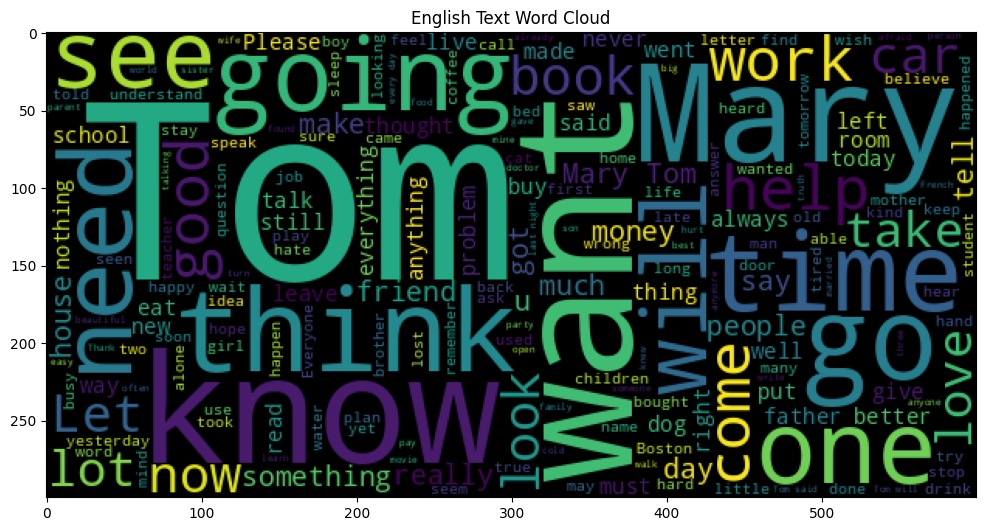

In [13]:
plt.figure(figsize=(12,8))
wc = WordCloud(width=600,height=300,random_state=101).generate(' '.join(df.english))
plt.imshow(wc)
plt.title('English Text Word Cloud');

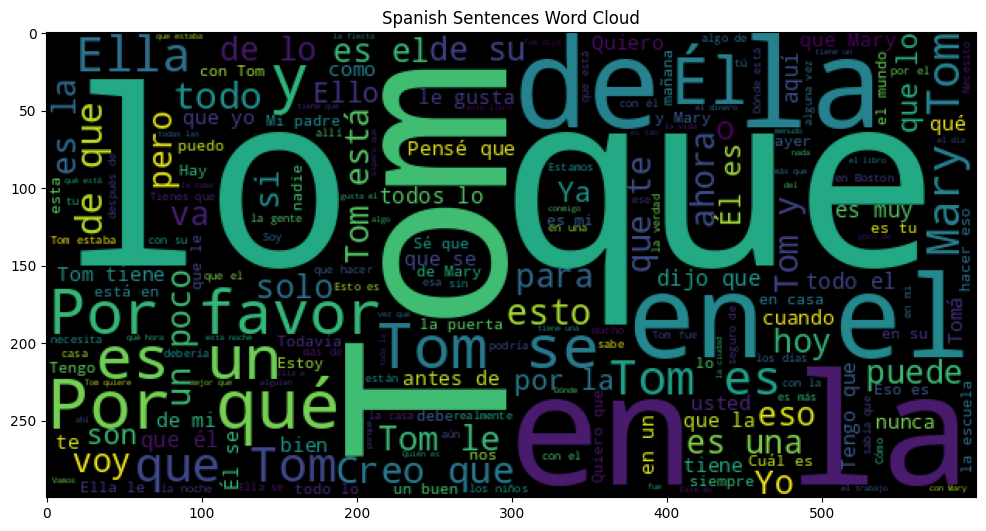

In [14]:
plt.figure(figsize=(12,8))
wc = WordCloud(width=600,height=300,random_state=101).generate(' '.join(df['spanish']))
plt.imshow(wc)
plt.title('Spanish Sentences Word Cloud');

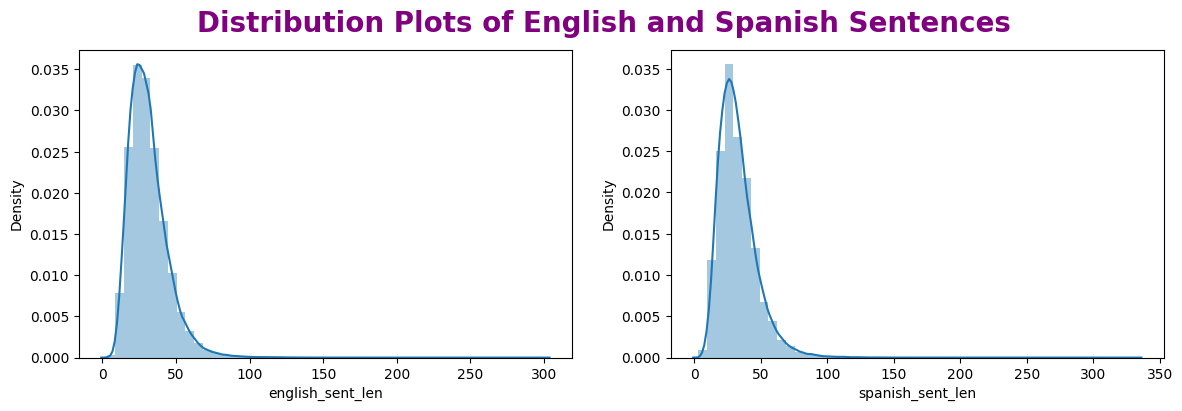

In [15]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(14,4))
sns.distplot(df['english_sent_len'],ax=axes[0])
sns.distplot(df['spanish_sent_len'],ax=axes[1])
plt.suptitle('Distribution Plots of English and Spanish Sentences',fontweight='bold',fontsize=20,color='purple')
plt.show();

## Text Preprocessing

In [16]:
def clean_and_preprocess_text(data,col):
    data[col] = data[col].apply(clean_html)
    data[col] = data[col].apply(punct)
    data[col] = data[col].apply(remove_)
    data[col] = data[col].apply(remove_digits)
    data[col] = data[col].apply(remove_links)
    data[col] = data[col].apply(removeStopWords)
    data[col] = data[col].apply(remove_special_characters)
    data[col] = data[col].apply(email_address)
    data[col] = data[col].apply(non_ascii)
    data[col] = data[col].apply(lower)
    return data

In [17]:
preprocessed_df = clean_and_preprocess_text(df,'english')
preprocessed_df.head()

,english,spanish,english_sent_len,spanish_sent_len
0,go,Ve.,3,3
1,go,Vete.,3,5
2,go,Vaya.,3,5
3,go,Váyase.,3,7
4,h,Hola.,3,5


In [18]:
preprocessed_df['spanish'] = preprocessed_df['spanish'].apply(lambda x: '<start> ' + x + ' <end>')

## Text Tokenization

In [19]:
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(preprocessed_df.english)

In [20]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_vocab_size

14255

In [21]:
eng_sequences = eng_tokenizer.texts_to_sequences(preprocessed_df.english)
eng_sequences = pad_sequences(eng_sequences,maxlen=max_eng_len,padding='post')
eng_sequences

array([[  10,    0,    0, ...,    0,    0,    0],
       [  10,    0,    0, ...,    0,    0,    0],
       [  10,    0,    0, ...,    0,    0,    0],
       ...,
       [  76,    7,  626, ...,    0,    0,    0],
       [ 105,  763,   16, ...,    0,    0,    0],
       [ 109,  882,   78, ...,   91,   20, 2444]], dtype=int32)

In [22]:
esp_tokenizer = Tokenizer()
esp_tokenizer.fit_on_texts(preprocessed_df.spanish)

In [23]:
esp_vocab_size = len(esp_tokenizer.word_index) + 1
esp_vocab_size

28935

In [24]:
esp_sequences = esp_tokenizer.texts_to_sequences(preprocessed_df.spanish)
esp_sequences = pad_sequences(esp_sequences,maxlen=max_esp_len,padding='post')
esp_sequences

array([[   1,  394,    2, ...,    0,    0,    0],
       [   1, 1793,    2, ...,    0,    0,    0],
       [   1,  524,    2, ...,    0,    0,    0],
       ...,
       [  30,  174,   71, ...,   56, 2248,    2],
       [9527,   20,   19, ...,   19,  663,    2],
       [   3,  151, 1503, ...,   43, 3156,    2]], dtype=int32)

## Splitting the padded sequences into train and test sets

In [25]:
X_train, X_test, y_train, y_test = train_test_split(eng_sequences,esp_sequences,test_size=0.3,shuffle=True,random_state=101)

## Model Architecture

In [26]:
K.clear_session()

latent_dim = 200 
embedding_dim = 100 

encoder_inputs = Input(shape=(max_eng_len,))
encoder_emb = Embedding(eng_vocab_size, embedding_dim, trainable=True)(encoder_inputs)

encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_emb)

encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_output2)
encoder_states = [state_h,state_c]

decoder_inputs = Input(shape=(max_esp_len,))
decoder_emb = Embedding(esp_vocab_size, embedding_dim, trainable=True)(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_bwd_state = decoder_lstm(decoder_emb, initial_state=encoder_states) 

attn_layer = Attention()
attn_outputs = attn_layer([decoder_outputs, encoder_outputs]) 

decoder_concat_outputs = Concatenate(axis=-1,name='concat_layer')([decoder_outputs, attn_outputs])

decoder_dense = Dense(esp_vocab_size,activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 100)      1425500     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 30, 200),    240800      ['embedding[0][0]']              
                                 (None, 200),                                                     
                                 (None, 200)]                                                     
                                                                                              

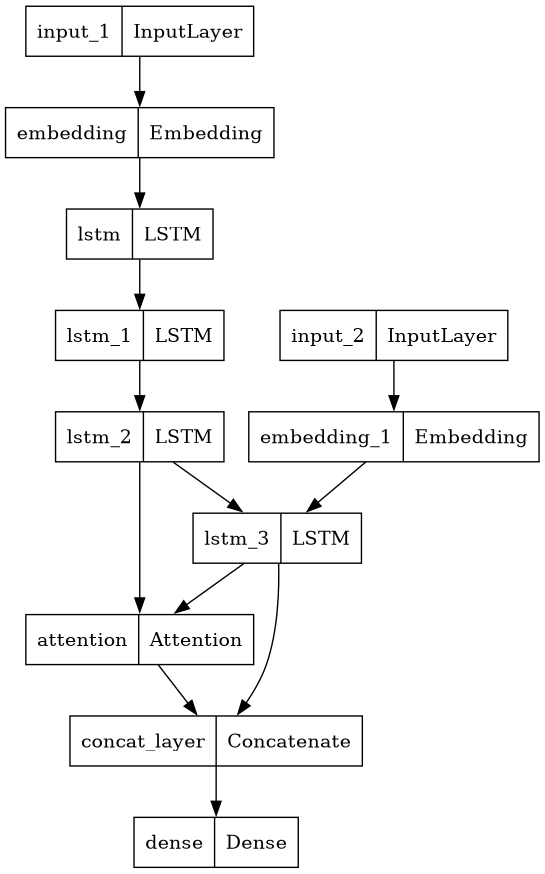

In [27]:
plot_model(model,to_file='model.png',dpi=100)

In [28]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [29]:
es = EarlyStopping(monitor='val_accuracy',mode='max',patience=5,restore_best_weights=True,verbose=1)
mc = ModelCheckpoint(filepath='english_to_spanish_translator.keras',monitor='val_accuracy',mode='max',verbose=2,save_best_only=True)

r = model.fit([X_train,y_train],
             y_train.reshape(y_train.shape[0],y_train.shape[1],1),
             epochs=25,
             batch_size=512,
             callbacks=[es,mc],
             validation_data=([X_test,y_test],y_test.reshape(y_test.shape[0],y_test.shape[1],1)))

Epoch 1/25
191/191 [==============================] - ETA: 0s - loss: 2.9878 - accuracy: 0.5930
Epoch 1: val_accuracy improved from -inf to 0.64124, saving model to english_to_spanish_translator.keras
191/191 [==============================] - 1510s 8s/step - loss: 2.9878 - accuracy: 0.5930 - val_loss: 2.4827 - val_accuracy: 0.6412
Epoch 2/25
191/191 [==============================] - ETA: 0s - loss: 1.9912 - accuracy: 0.6902
Epoch 2: val_accuracy improved from 0.64124 to 0.75039, saving model to english_to_spanish_translator.keras
191/191 [==============================] - 1491s 8s/step - loss: 1.9912 - accuracy: 0.6902 - val_loss: 1.6497 - val_accuracy: 0.7504
Epoch 3/25
191/191 [==============================] - ETA: 0s - loss: 1.3961 - accuracy: 0.7934
Epoch 3: val_accuracy improved from 0.75039 to 0.82095, saving model to english_to_spanish_translator.keras
191/191 [==============================] - 1497s 8s/step - loss: 1.3961 - accuracy: 0.7934 - val_loss: 1.1968 - val_accuracy:

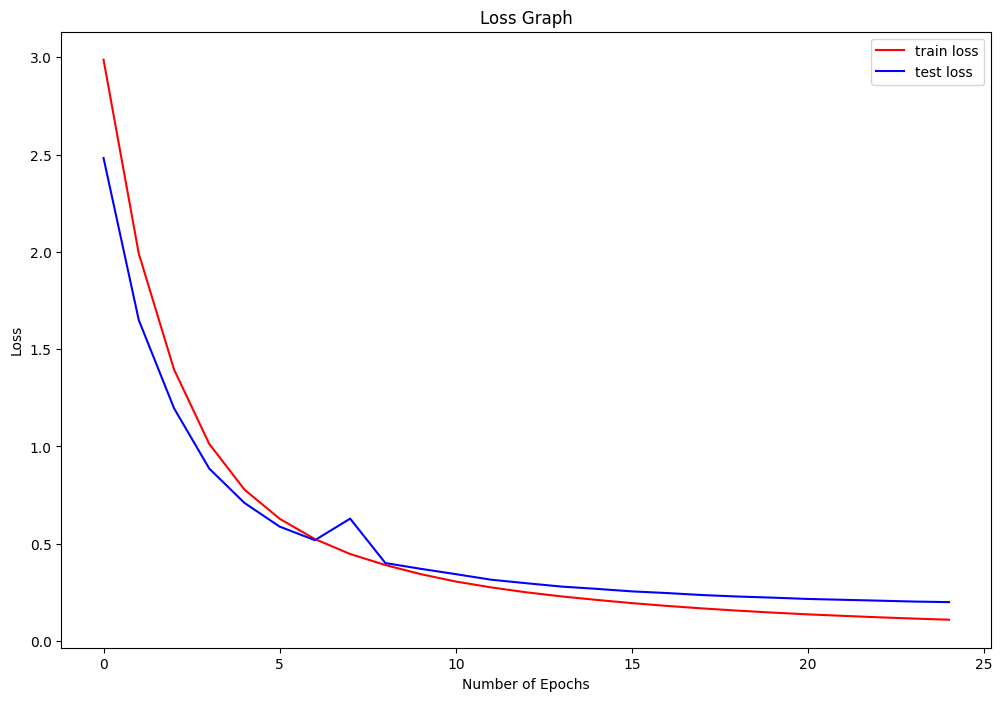

In [30]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

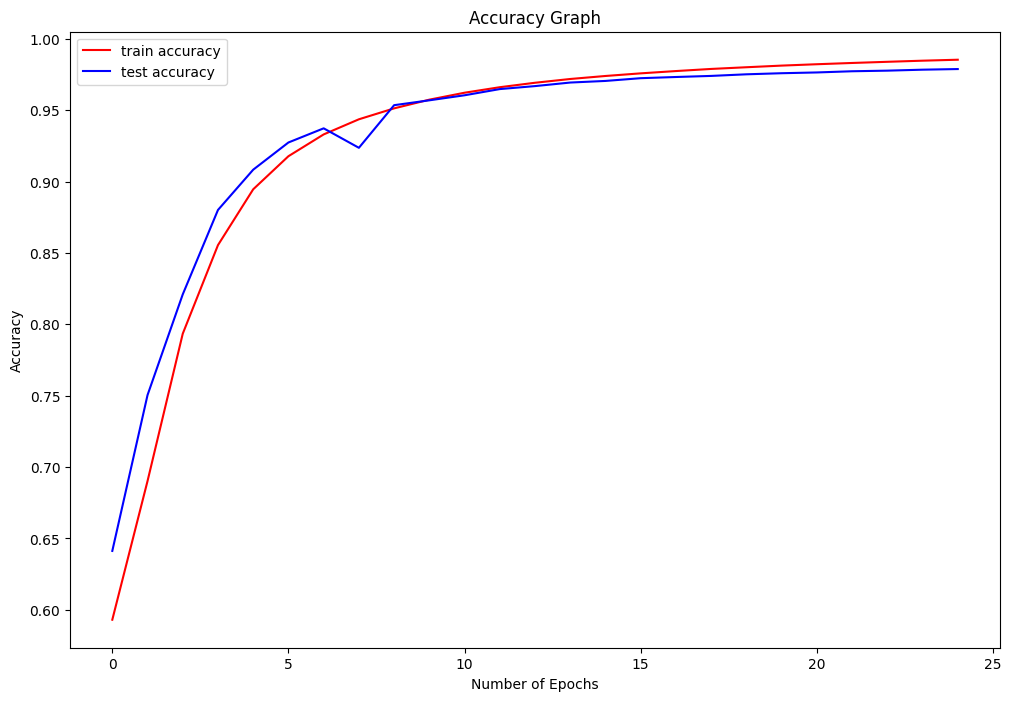

In [31]:
plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [32]:
model = load_model("/kaggle/input/eng-to-spanish-translator/english_to_spanish_translator.keras")
model

In [33]:
loss, acc = model.evaluate([X_test,y_test],y_test.reshape(y_test.shape[0],y_test.shape[1],1))
print("Sparse Categorical Crossentropy Loss:",loss)
print("Accuracy:",np.round(acc*100,2))

1304/1304 [==============================] - 297s 227ms/step - loss: 0.2961 - accuracy: 0.9677
Sparse Categorical Crossentropy Loss: 0.2960691452026367
Accuracy: 96.77


In [34]:
reverse_target_word_index = eng_tokenizer.index_word
reverse_source_word_index = esp_tokenizer.index_word
target_word_index = esp_tokenizer.word_index

In [35]:
# Define inference encoder model
inf_encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [36]:
# Define inference decoder model
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs = Input(shape=(1,))
decoder_emb_layer = Embedding(esp_vocab_size,embedding_dim,trainable=True)
decoder_emb = decoder_emb_layer(decoder_inputs)

decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_emb, initial_state=decoder_states_inputs)
decoder_states = [decoder_state_h, decoder_state_c]

encoder_out_as_inp = Input(shape=(latent_dim,))
attention_layer = Attention()
attn_out_inf = attention_layer([decoder_outputs, encoder_out_as_inp])

decoder_concat_output = Concatenate(axis=-1)([decoder_outputs, attn_out_inf])

decoder_outputs = decoder_dense(decoder_concat_output)

inf_decoder_model = Model([decoder_inputs,encoder_out_as_inp,decoder_states_inputs], [decoder_outputs] + decoder_states)

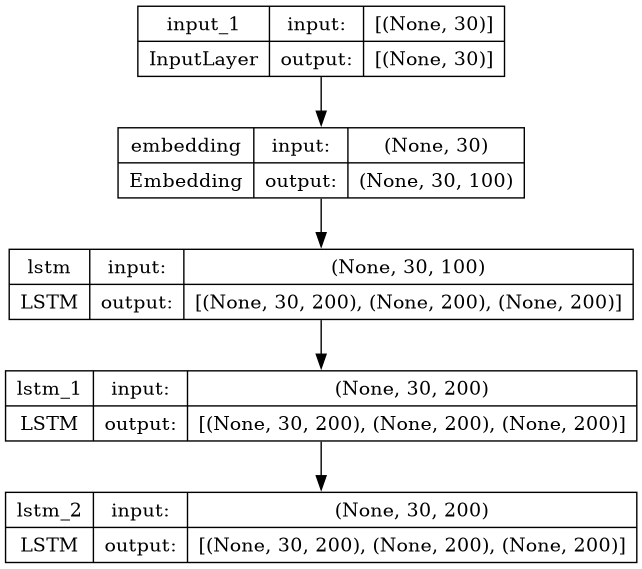

In [37]:
plot_model(inf_encoder_model,'inf_encoder_model.png',show_shapes=True,dpi=100)

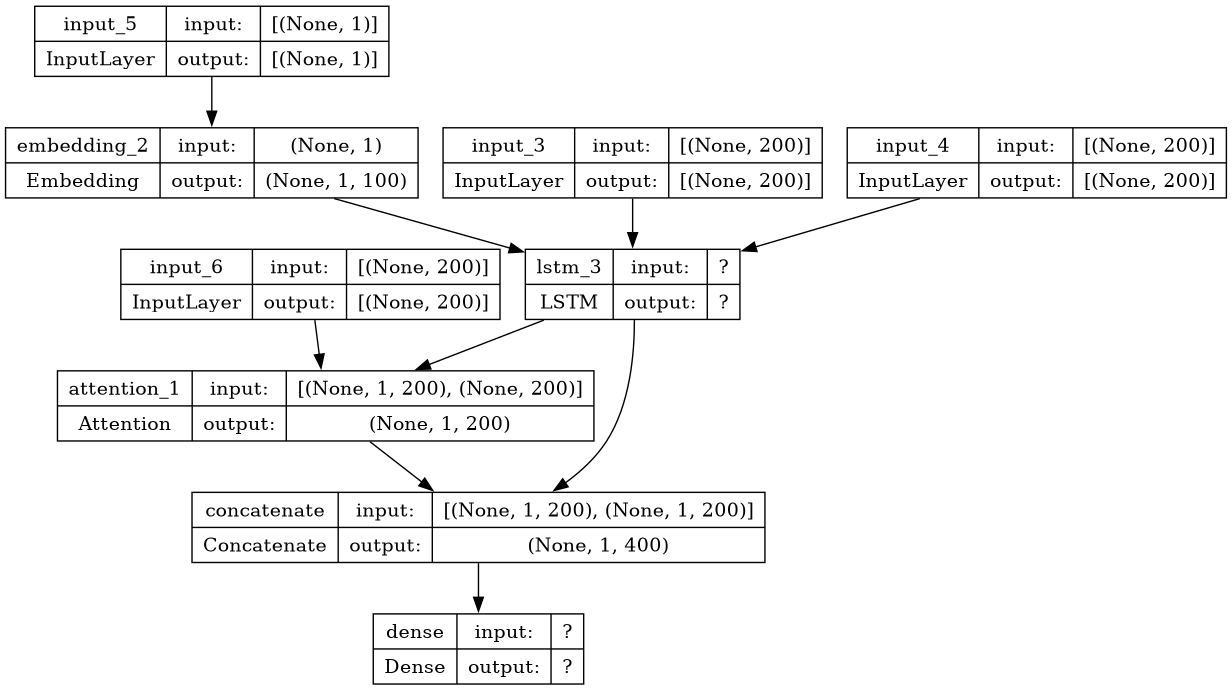

In [38]:
plot_model(inf_decoder_model,'inf_decoder_model.png',dpi=100,show_shapes=True)

In [39]:
def decode_sequences(input_sequence):
    # Encode the input sequence to get the encoder states
    encoder_out, encoder_state_h, encoder_state_c = inf_encoder_model.predict(input_sequence)
    
    # Generate empty target sequence of length 1
    target_sequence = np.zeros((1,1))
    
    # Populate the first token of target sequence with the start token
    target_sequence[0,0] = esp_tokenizer.word_index['start']
    
    # Define stop condition
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # Predict the next token and update the decoder states
        output_tokens, h, c = inf_decoder_model.predict([target_sequence, encoder_out, [encoder_state_h,encoder_state_c]])
        
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = esp_tokenizer.index_word[sampled_token_index]
        
        # Append the sampled token to the decoded sentence
        if sampled_token != 'end':
            decoded_sentence += ' ' + sampled_token
            
        # Exit condition: either hit max length or find stop token
        if sampled_token == 'end' or len(decoded_sentence.split()) > max_esp_len:
            stop_condition = True
            
        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        
        # Update the states
        states_value = [h, c]
        
    return decoded_sentence

In [40]:
def sequence_to_language(input_sequence,tokenizer,lang):
    res = ''
    
    if lang == 'eng':
        for idx in input_sequence:
            if idx != 0:
                res = res + tokenizer.index_word[idx] + ' '
    
    elif lang == 'esp':
        for idx in input_sequence:
            if idx > 0:
                if tokenizer.index_word[idx] != 'start' and tokenizer.index_word[idx] != 'end':
                    res = res + tokenizer.index_word[idx] + ' '
                    
    return res

In [41]:
predicted_spanish_translations= []

for i in range(20):
    print("English Sentence:",sequence_to_language(X_test[i],eng_tokenizer,'eng'))
    print("Original Spanish Translation:",sequence_to_language(y_test[i],esp_tokenizer,'esp'))
    pred_spanish_sentence = decode_sequences(X_test[i].reshape(1,max_eng_len))
    print("Predicted Spanish Translation:",pred_spanish_sentence)
    predicted_spanish_translations.append(pred_spanish_sentence)

English Sentence: do mobile phone 
Original Spanish Translation: ¿tenés celular 
1/1 [==============================] - 0s 24ms/step
Predicted Spanish Translation:  start start start start start start start start start start start start start start start start
English Sentence: know means lot tom 
Original Spanish Translation: sé que significa mucho para tom 
1/1 [==============================] - 0s 24ms/step
Predicted Spanish Translation:  start start start start start start start start start start start start start start start start
English Sentence: tom wondered mary going kiss 
Original Spanish Translation: tom se preguntaba si maría iba a besarlo 
1/1 [==============================] - 0s 24ms/step
Predicted Spanish Translation:  «¿vas «¿vas «¿vas «¿vas «¿vas «¿vas «¿vas «¿vas «¿vas «¿vas «¿vas «¿vas «¿vas «¿vas «¿vas «¿vas
English Sentence: tom washed face 
Original Spanish Translation: tom se lavó la cara 
1/1 [==============================] - 0s 26ms/step
Predicted Spanish Tr

In [42]:
original_esp_translations = []

for i in range(20):
    original_esp_translations.append(sequence_to_language(y_test[i],esp_tokenizer,'esp'))
    
references = []

for trans in original_esp_translations:
    ref = trans.split()
    references.append(ref)

In [43]:
smooth = SmoothingFunction().method4

for i in range(20):
    print("Original Spanish Sentence:",' '.join(references[i]))
    print("Predicted Spanish Sentence:",predicted_spanish_translations[i])
    print("BLEU Score:",sentence_bleu(references[i],predicted_spanish_translations[i],smoothing_function=smooth,weights=(0.25,0.25,0.25,0.25)))

Original Spanish Sentence: ¿tenés celular
Predicted Spanish Sentence:  start start start start start start start start start start start start start start start start
BLEU Score: 0.0766937791148446
Original Spanish Sentence: sé que significa mucho para tom
Predicted Spanish Sentence:  start start start start start start start start start start start start start start start start
BLEU Score: 0.0810937981206948
Original Spanish Sentence: tom se preguntaba si maría iba a besarlo
Predicted Spanish Sentence:  «¿vas «¿vas «¿vas «¿vas «¿vas «¿vas «¿vas «¿vas «¿vas «¿vas «¿vas «¿vas «¿vas «¿vas «¿vas «¿vas
BLEU Score: 0.1851983882259444
Original Spanish Sentence: tom se lavó la cara
Predicted Spanish Sentence:  diablo diablo diablo diablo diablo diablo diablo diablo diablo diablo diablo diablo diablo diablo diablo diablo
BLEU Score: 0.19329517375069913
Original Spanish Sentence: los estudiantes no pueden entrar en la sala de profesores
Predicted Spanish Sentence:  start start start start start